In [ ]:
!pip install pandasql
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
import warnings
import seaborn as sns
import math
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Data Handling

In [ ]:
cpu_years = pd.read_excel('/content/gdrive/MyDrive/Capstone/cpu_names.xlsx')
df = pd.read_csv('/content/gdrive/MyDrive/Capstone/fps_videogames.csv')

In [ ]:
rename = {'CpuName': 'CPU Name', 'CpuNumberOfCores': 'CPU Cores', 'CpuNumberOfThreads': 'CPU Threads',
          'CpuBaseClock': 'CPU Base Clock', 'CpuCacheL1': 'CPU Cache L1', 'CpuCacheL2': 'CPU Cache L2',
          'CpuCacheL3': 'CPU Cache L3', 'CpuDieSize': 'CPU Die Size', 'CpuFrequency': 'CPU Frequency',
          'CpuMultiplier': 'CPU Multiplier', 'CpuMultiplierUnlocked': 'CPU Multiplier Unlocked',
          'CpuProcessSize': 'CPU Process Size', 'CpuTDP': 'CPU TDP', 'CpuNumberOfTransistors': 'CPU Transistors',
          'CpuTurboClock': 'CPU Turbo Clock',
          'GpuName': 'GPU Name', 'GpuArchitecture': 'GPU Arcchitecture', 'GpuBandwidth': 'GPU Bandwidth',
          'GpuBaseClock': 'GPU Base Clock', 'GpuBoostClock': 'GPU Boost Clock', '\'GpuBus': 'GPU Bus',
          'GpuNumberOfComputeUnits': 'GPU Compute Units', 'GpuDieSize': 'GPU Die Size', 'GpuDirectX': 'GPU Direct X',
          'GpuNumberOfExecutionUnits': 'GPU Execution Units', 'GpuFP32Performance': 'GPU FP32 Performance',
          'GpuMemoryBus': 'GPU Memory Bus', 'GpuMemorySize': 'GPU Memory Size', 'GpuMemoryType': 'GPU Memory Type',
          'GpuOpenCL': 'GPU Open CL', 'GpuOpenGL': 'GPU Open GL', 'GpuPixelRate': 'GPU Pixel Rate', 'GpuProcessSize': 'GPU Process Size',
          'GpuNumberOfROPs': 'GPU Number of ROPs', 'GpuShaderModel': 'GPU Shader Model', 'GpuNumberOfShadingUnits': 'GPU Shading Units',
          'GpuNumberOfTMUs': 'GPU TMUs', 'GpuTextureRate': 'GPU Texture Rate', 'GpuNumberOfTransistors': 'GPU Transistors', 'GpuVulkan': 'GPU Vulkan',
          'GameName': 'Game', 'GameResolution': 'Game Resolution', 'GameSetting': 'Game Settings'}

df.rename(columns=rename, inplace=True) #Rename columns 

df['CPU Name'] = df['CPU Name'].apply(lambda x: x.replace('-', ' '))
df['CPU Brand'] = df['CPU Name'].apply(lambda x: x.split(' ')[0])

df['CPU Type'] = df['CPU Name'].apply(lambda x: re.findall('[a-zA-Z]+', x)[-1].upper() if x[-1].isalpha() else 'Normal')
df['CPU Name'] = df['CPU Name'].apply(lambda x: x.replace(re.findall('[a-zA-Z]+', x)[-1], '', -1).strip() if x[-1].isalpha() else x)

df['CPU Model'] = df['CPU Name']
df['CPU Model'] = df.apply(lambda x : x['CPU Model'].replace(str(x['CPU Brand']), '').strip(), axis=1)

cpu_series = ['A4', 'A6', 'Athlon', 'Athlon 64', 'Athlon II', 'FX', 'Ryzen', 'Core', 'Pentium']

for series in cpu_series:
    df['CPU Series Temp'] = df['CPU Model'].apply(lambda x: series if series in x else 'NA')
    ind = df[df['CPU Series Temp']==series].index
    df.loc[ind, 'CPU Series'] = df.loc[ind, 'CPU Series Temp']

df['CPU Model'] = df.apply(lambda x : x['CPU Model'].replace(str(x['CPU Series']), '').strip(), axis=1)
df.drop(['CPU Series Temp'], axis=1, inplace=True)

df['CPU Generation'] = df['CPU Model'].apply(lambda x: x.split(' ')[-1][1] if x.split(' ')[-1][0].isalpha() else x.split(' ')[-1][0]).tolist()

core_ind = df[df['CPU Series']=='Core'].index

df.loc[core_ind, 'CPU Generation'] = df.loc[core_ind, 'CPU Model'].apply(lambda x: x.split(' ')[-1][0]+'0' if len(x.split(' ')[-1])==3 else x.split(' ')[-1][0])
older_gen = {'90': 1, '80': 0, '70': -1, '60': -2, '50': -3, '40': -4, '(': None}
df['CPU Generation'] = df['CPU Generation'].replace(older_gen)

df['CPU Model'] = df.apply(lambda x : x['CPU Model'].replace(str(x['CPU Model'].split(' ')[-1]), '').strip(), axis=1)

df['CPU Model'] = df['CPU Model'].fillna('NA')
df['CPU Series'] = df['CPU Series'].fillna('NA')
df.replace({'?': None}, inplace=True)

In [ ]:
cpu_detail_cols = ['CPU Brand', 'CPU Model', 'CPU Series', 'CPU Generation', 'CPU Cores']

cpu_years['CPU Name'] = cpu_years['CPU Name'].apply(lambda x:x.replace('-', ' '))
# cpu_years.drop(['month'], axis=1, inplace=True)
cpu = pd.merge(df[cpu_detail_cols + ['CPU Name', 'CPU Transistors']], cpu_years, how='left', on='CPU Name')
cpu = cpu[~cpu['CPU Transistors'].isna() & ~cpu['CPU Generation'].isna()] #dropping na transistors

cpu.drop(['Unnamed: 3'], axis=1, inplace=True)
numeric_cols = ['CPU Transistors', 'CPU Generation']
cpu[numeric_cols] = cpu[numeric_cols].apply(pd.to_numeric)

cpu.dropna(inplace = True)
cpu = cpu.drop_duplicates()
cpu['Adjusted Transistors'] = cpu['CPU Transistors']/cpu['CPU Cores']
cpu['Adjusted Transistors'] = cpu['Adjusted Transistors'].apply(int)

cpu.sort_values('CPU Release Year')

temp = cpu.copy()
new_cols = [x.replace(' ', '_') for x in cpu.columns]
print(new_cols)
temp.columns = new_cols
temp.head()

In [ ]:
cpu.dropna(inplace = True)
cpu = cpu.drop_duplicates()
cpu['Adjusted Transistors'] = cpu['CPU Transistors']/cpu['CPU Cores']
cpu['Adjusted Transistors'] = cpu['Adjusted Transistors'].apply(int)

In [ ]:
cpu.sort_values('CPU Release Year')

,CPU Brand,CPU Model,CPU Series,CPU Generation,CPU Cores,CPU Name,CPU Transistors,CPU Release Year,month,Adjusted Transistors
105333,AMD,X2,Athlon 64,3,2,AMD Athlon 64 X2 3800+,154,2006.0,5.0,77
30035,Intel,Dual Core,Pentium,2,2,Intel Pentium Dual Core E2200,105,2007.0,12.0,52
131118,Intel,Dual Core,Pentium,2,2,Intel Pentium Dual Core E2180,105,2007.0,9.0,52
0,Intel,i7,Core,1,4,Intel Core i7 920,731,2008.0,11.0,182
30061,Intel,,Pentium,5,2,Intel Pentium E5200,228,2008.0,8.0,114
...,...,...,...,...,...,...,...,...,...,...
29581,AMD,X4,Athlon,9,4,AMD Athlon X4 950,1178,2017.0,7.0,294
24615,AMD,7,Ryzen,2,8,AMD Ryzen 7 2700,4800,2018.0,4.0,600
25531,AMD,5,Ryzen,2,6,AMD Ryzen 5 2600,4800,2018.0,4.0,800
23722,AMD,5,Ryzen,3,6,AMD Ryzen 5 3600,3800,2019.0,7.0,633


In [ ]:
temp = cpu.copy()
new_cols = [x.replace(' ', '_') for x in cpu.columns]
print(new_cols)
temp.columns = new_cols
temp.head()

['CPU_Brand', 'CPU_Model', 'CPU_Series', 'CPU_Generation', 'CPU_Cores', 'CPU_Name', 'CPU_Transistors', 'CPU_Release_Year', 'month', 'Adjusted_Transistors']


,CPU_Brand,CPU_Model,CPU_Series,CPU_Generation,CPU_Cores,CPU_Name,CPU_Transistors,CPU_Release_Year,month,Adjusted_Transistors
0,Intel,i7,Core,1,4,Intel Core i7 920,731,2008.0,11.0,182
2,Intel,i5,Core,4,4,Intel Core i5 4690,1400,2014.0,5.0,350
259,Intel,i5,Core,4,4,Intel Core i5 4570,1400,2013.0,6.0,350
719,Intel,i5,Core,4,4,Intel Core i5 4590,1400,2014.0,5.0,350
963,Intel,i5,Core,2,4,Intel Core i5 2400,1160,2011.0,1.0,290


# Inference

In [ ]:
out = sqldf('''

    select max(Adjusted_Transistors) as Max_transistors, count(Adjusted_Transistors) as Models_released,
    avg(Adjusted_Transistors) as Avg_transistors,
    case when month < 1 then CPU_Release_Year - 1 
    when month > 9 then CPU_Release_Year + 1
    else CPU_Release_Year
    end as new_year
    from temp group by new_year

''')

In [ ]:
out['Double_Transistors'] = 2*out['Max_transistors']
out['Actual_Transistors'] = out['Max_transistors'].shift(-2)

In [ ]:
# Manual Imputation of Incorrect Data
out = out.replace(out.iloc[13][0], 1200) 
out = out.replace(out.iloc[6][0], 1303)
out = out.replace(out.iloc[7][0], 1303)
out = out.replace(out.iloc[11][0], 3100)

In [ ]:
out

,Max_transistors,Models_released,Avg_transistors,new_year,Double_Transistors,Actual_Transistors
0,77,1,77.000000,2006.0,154,114.0
1,52,1,52.000000,2007.0,104,205.0
2,114,2,83.000000,2008.0,228,205.0
3,205,14,159.428571,2009.0,410,312.0
4,205,32,155.687500,2010.0,410,1303.0
5,312,27,247.703704,2011.0,624,1303.0
6,1303,30,290.433333,2012.0,756,1303.0
7,1303,35,412.571429,2013.0,1400,1303.0
8,1303,18,521.722222,2014.0,1400,380.0
9,1303,6,1303.000000,2015.0,1400,3100.0


In [ ]:
stat1, p1 = stats.ks_2samp(out['Actual_Transistors'][:-2], out['Double_Transistors'][:-2])

In [ ]:
stat2, p2 = stats.mannwhitneyu(out['Actual_Transistors'][:-2], out['Double_Transistors'][:-2])

In [ ]:
n1 = 12
n2 = 12
mu = (n1*n2)/2
sigma = math.sqrt((n1*n2)*(n1+n2+1)/12)
z = (stat2 - mu)/sigma
r = abs(z)/math.sqrt(n1)

In [ ]:
r

0.3

In [ ]:
kde_df = out[['Actual_Transistors', 'Double_Transistors']]

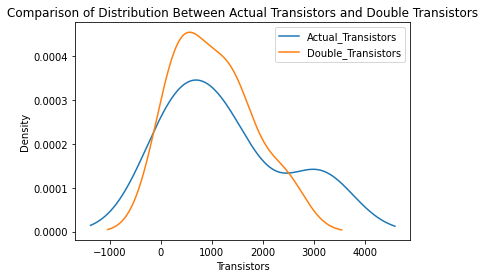

In [ ]:
ax = kde_df.plot.kde()
plt.xlabel('Transistors')
plt.ylabel('Density')
plt.title("Comparison of Distribution Between Actual Transistors and Double Transistors")
plt.savefig("KDE Plot Of Distributions")

In [ ]:
one = out['Double_Transistors'][:-2]
two = out['Actual_Transistors'][:-2]

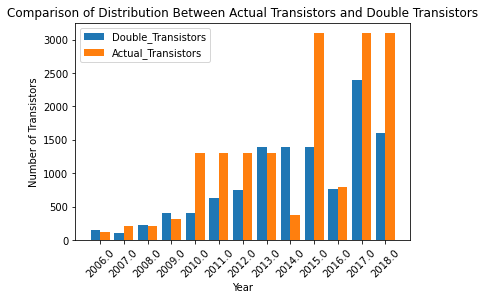

<Figure size 432x288 with 0 Axes>

In [ ]:
X = out['new_year'][:-2]
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, one, 0.4, label = 'Double_Transistors')
plt.bar(X_axis + 0.2, two, 0.4, label = 'Actual_Transistors')
plt.xticks(X_axis, X)
plt.xlabel("Year")
plt.ylabel("Number of Transistors")
plt.title("Comparison of Distribution Between Actual Transistors and Double Transistors")
plt.xticks(rotation = 45)
plt.legend()
plt.show()
plt.savefig("Bar Plot Of Distributions")

In [ ]:
errorBar_df = out.copy()

In [ ]:
errorBar_df['Errors'] = abs(errorBar_df['Double_Transistors'] - errorBar_df['Actual_Transistors'])

In [ ]:
errorBar_df

,Max_transistors,Models_released,Avg_transistors,new_year,Double_Transistors,Actual_Transistors,Errors
0,77,1,77.000000,2006.0,154,114.0,40.0
1,52,1,52.000000,2007.0,104,205.0,101.0
2,114,2,83.000000,2008.0,228,205.0,23.0
3,205,14,159.428571,2009.0,410,312.0,98.0
4,205,32,155.687500,2010.0,410,1303.0,893.0
5,312,27,247.703704,2011.0,624,1303.0,679.0
6,1303,30,290.433333,2012.0,756,1303.0,547.0
7,1303,35,412.571429,2013.0,1400,1303.0,97.0
8,1303,18,521.722222,2014.0,1400,380.0,1020.0
9,1303,6,1303.000000,2015.0,1400,3100.0,1700.0


In [ ]:
sem_Actual = out['Actual_Transistors'].std()/math.sqrt(12)
sem_Actual

328.99870268364486

In [ ]:
sem_Expected = out['Double_Transistors'].std()/math.sqrt(12)
sem_Expected

216.76043392253513

Text(0, 0.5, 'Actual Number of Transistors')

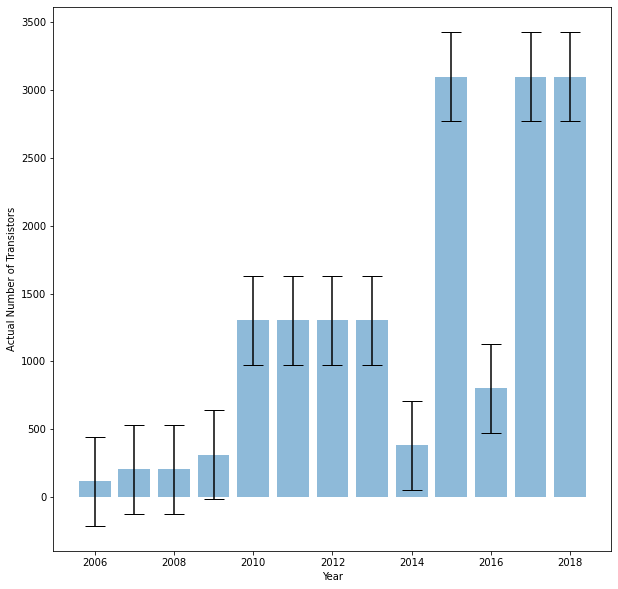

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.bar(errorBar_df['new_year'], errorBar_df['Actual_Transistors'],
       yerr=sem_Actual,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
plt.xlabel('Year')
plt.ylabel('Actual Number of Transistors')

Text(0, 0.5, 'Expected Number of Transistors')

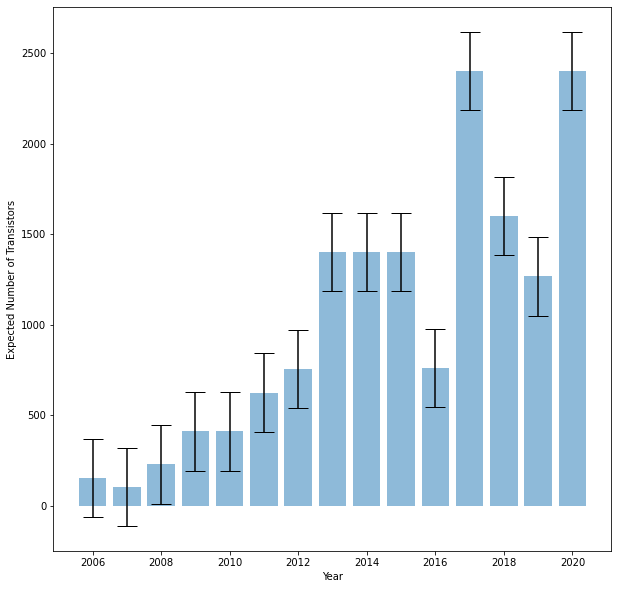

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.bar(errorBar_df['new_year'], errorBar_df['Double_Transistors'],
       yerr=sem_Expected,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
plt.xlabel('Year')
plt.ylabel('Expected Number of Transistors')